# Brief decription of the Project


Making use of the data made available by Lyft, I sought to learn more about Bike Sharing usage in San Francisco.

Specifically, the goal of this project is 2-fold:

- Quantify the business and user trends over time.


- Forecast daily bike usage.


## 1 - Quantify the business trends over time.

Quantify Macro trends over the last 2 years: 

  - Total Number of trips per month for the last 3 years

  - Trip duration distribution

  - Gender gap in user profile over time.

  - Median user age over time

Identify temporal trends in the data, starting with weekdays vs weekends:

- Trip start time distribution: weekdays vs weekends
    
- Trip duration distribution: weekdays vs weekends


Analyse structure of fluctuations in trip counts across stations and across days.

Analyse distribution of most common bike routes


## 2 - Forecast daily bike usage.


How well can you predict #trips a day based on historical data?

Does more past data help or hurt predictions?

Can NN beat simple forecasting analyses (such as Linear Regression)?



## Data used and licensing

The Data is available [here](https://www.lyft.com/bikes/bay-wheels/system-data)

Each trip is anonymized and includes:

Trip Duration (seconds)

Start Time and Date

End Time and Date

Start Station ID

Start Station Name

Start Station Latitude

Start Station Longitude

End Station ID

End Station Name

End Station Latitude

End Station Longitude

Bike ID

User Type (Subscriber or Customer – “Subscriber” = Member or “Customer” = Casual)

Member Year of Birth

Member Gender


In [1]:
# imports
%matplotlib inline
import numpy as np
import glob
import math
import scipy.stats as spstats
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
#import plotly.graph_objects as go

In [2]:
# Define data source

extension = 'csv'
all_filenames = [i for i in glob.glob('LyftData/*.{}'.format(extension))]
all_filenames_sorted = sorted(all_filenames)

In [3]:
# Define how data frames will be created  (1 per year)

def create_dataframe_year(year,file_list):
    dateparse = lambda x: pd.datetime.strptime(x.split('.')[0], '%Y-%m-%d %H:%M:%S')
    data_frame = pd.concat([pd.read_csv(f, parse_dates=['start_time'], date_parser=dateparse) for f in file_list if year in f ])
    return data_frame

In [4]:
# Create one dataframe per year

data_frame_2017 = create_dataframe_year(year = '2017',file_list = all_filenames_sorted)
data_frame_2018 = create_dataframe_year(year = '2018',file_list = all_filenames_sorted)
data_frame_2019 = create_dataframe_year(year = '2019',file_list = all_filenames_sorted)

/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/diogopeixoto/anaconda3/envs/time_series_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [5]:
# Sort monthly dataframes

data_frame_2017_sorted = data_frame_2017.sort_values(by=['start_time'])
data_frame_2018_sorted = data_frame_2018.sort_values(by=['start_time'])
data_frame_2019_sorted = data_frame_2019.sort_values(by=['start_time'])

## Business and usage trends over time

First I wanted to sort and process the data on a monthly basis to look for trends in usage and user characteristics

In [6]:
# Define function to extract monthly features of interest

def extract_monthly_features(data_frame, year,birth_year_percentile_low=5,birth_year_percentile_high=95):
    
    age_percentiles_month = np.zeros((12,2))
    
    _col = ['num_trips', 'median_trip_duration', 'median_user_age','high_age_percentile','low_age_percentile', 
            'percent_user_female','percent_user_subscriber']
#     month_name = data_frame["start_time"].apply(lambda x: str(x.month + "_" + year).unique()
    month_names = data_frame["start_time"].apply(lambda x: x.month_name())

    uniq_m_names = month_names.unique()
    df_labels = month_names.apply(lambda x: str(x) + '_' + year).unique()
    df = pd.DataFrame(index=df_labels, columns=_col)
    #print(df.index)
        
    for df_label, m_name in zip(df_labels, uniq_m_names):
        
        data_frame_month = data_frame[month_names == m_name]
        if not data_frame_month.empty:
            # Total number of trips/month
            num_trips_tmp = data_frame_month.shape[0]
            
            # Median duration of trips/month
            median_duration_tmp = np.nanmedian(data_frame_month['duration_sec'])       
            
            # Median age of trips per month for the 3 years
            median_birth_year_tmp = np.nanmedian(data_frame_month['member_birth_year'])
            median_age_tmp = float(year) - median_birth_year_tmp
            high_age_percentile_tmp = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], birth_year_percentile_low)
            low_age_percentile_tmp = float(year) - np.nanpercentile(data_frame_month['member_birth_year'], birth_year_percentile_high)
            
            
            # Male and female percentage of trips per month for the 3 years
            num_males_tmp = sum(data_frame_month['member_gender'] == "Male")
            num_females_tmp = sum(data_frame_month['member_gender'] == "Female")
            
            percent_female_tmp = num_females_tmp/(num_females_tmp + num_males_tmp)
            percent_gender_report = (num_females_tmp + num_males_tmp)/num_trips_tmp
            
            # User type percentage per month for the 3 years
            num_subscribers_tmp = sum(data_frame_month['user_type'] == "Subscriber")
            num_customers_tmp = sum(data_frame_month['user_type'] == "Customer")
            percent_subscriber_tmp = num_subscribers_tmp/(num_subscribers_tmp + num_customers_tmp)
            #print(m_name, df_label)
            df.loc[df_label] = [num_trips_tmp,median_duration_tmp,median_age_tmp,high_age_percentile_tmp, 
                                low_age_percentile_tmp,percent_female_tmp,percent_subscriber_tmp] 
    
    return df
    

In [7]:
# Create dataframes of extracted monthly features and concatenate them in a continuous df
df_monthly_2017 = extract_monthly_features(data_frame_2017_sorted,"2017")
df_monthly_2018 = extract_monthly_features(data_frame_2018_sorted,"2018")
df_monthly_2019 = extract_monthly_features(data_frame_2019_sorted,"2019")
df_new = pd.concat([df_monthly_2017,df_monthly_2018,df_monthly_2019], axis=0)

Once I had the monthly features I was able to plot trends within a year or across years

In [8]:
# Define function to plot monthly features of interest
def plot_monthly_features(current_df):
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_ul = fig.add_subplot(grid[0, 0])
    ax_ur = fig.add_subplot(grid[0, 1])
    ax_ll = fig.add_subplot(grid[1, 0])
    ax_lr = fig.add_subplot(grid[1, 1])


    # plot on the upper left
    monthly_counts = current_df.num_trips
    ax_ul.plot(monthly_counts, color='deeppink')
    ax_ul.set_xlim(0, len(monthly_counts))
    ax_ul.set(ylabel = 'number of trips /month')
    ax_ul.yaxis.label.set_fontsize(14)
    xlabels = current_df.index
    ax_ul.set_xticklabels(xlabels, rotation=90)

    # plot on the upper right
    median_duration = current_df.median_trip_duration
    ax_ur.plot(median_duration, color='deeppink')
    ax_ur.set_xlim(0, len(median_duration))
    ax_ur.set(ylabel = 'median trip duratyion(s)')
    ax_ur.yaxis.label.set_fontsize(14)
    ax_ur.set_xticklabels(xlabels, rotation=90)

    # plot on the lower left
    median_age = current_df.median_user_age
    high_age_percentile = current_df.high_age_percentile
    low_age_percentile = current_df.low_age_percentile
    ax_ll.plot(median_age, color='deeppink')
    ax_ll.plot(high_age_percentile, color='black')
    ax_ll.plot(low_age_percentile, color='green')
    ax_ll.set_xlim(0, len(median_age))
    ax_ll.set(ylabel = 'median age(years)')
    ax_ll.yaxis.label.set_fontsize(14)
    ax_ll.set_xticklabels(xlabels, rotation=90)

    # plot on the lower right
    percent_female = current_df.percent_user_female
    percent_subscribers = current_df.percent_user_subscriber
    ax_lr.plot(percent_female, color='deeppink')
    ax_lr.plot(percent_subscribers, color='black')
    ax_lr.set_xlim(0, len(percent_female))
    ax_lr.set(ylabel = 'percentage of users (%)')
    ax_lr.yaxis.label.set_fontsize(14)
    ax_lr.set_xticklabels(xlabels, rotation=90)


    plt.show()

For the purpose of completion I first looked at the trends across all available datasets

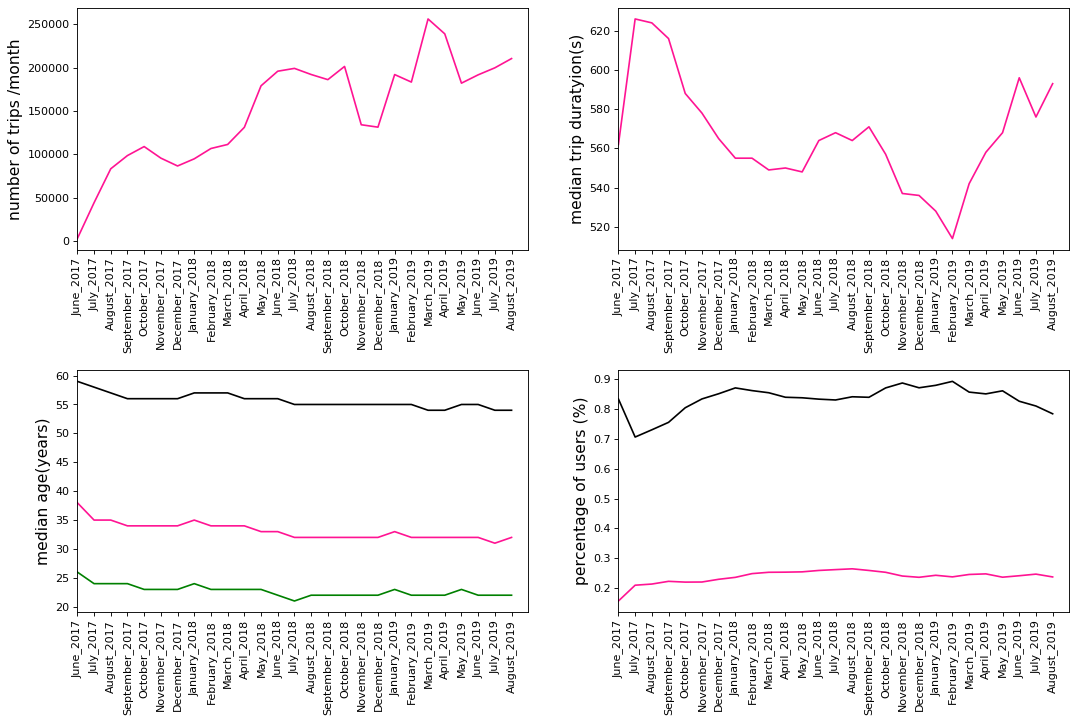

In [9]:
# Plot monthly features of interest over time 

plot_monthly_features(df_new)

## Macro usage trends

Initial impressions from the data at the macroscopic level:

- Overall the number of trips/month has been rising since the launch in the summer of 2017.

- The median trip duration has fluctuated but only within a narrow range: 500-630(s) or ~8.5-10/5 minutes.

- Median age as well as 5th and 95th percentile have been remarkably steady since the launch. This shows that despite the increase in the number of trips age-wise the demographic of the users has not expanded.

- Gender imbalance* in the user population is very striking and not showing any signs of improvement: % of female users has remained steady ~25%. Such a start underrepresentation should be a concern in terms of business expansion.

- High percentage of users who are subscribers (~80%) indicates the product is potentially "sticky", meaning users will repeatedly use the app/service over time, a positive indication for the business. A more detailed analysis of individual user behavior would require a user ID which is unfortunately not available.   

 
*Gender was reported in a binary way in the available data. While non-inclusive, "Male" and "Female" breakdown is the only possible sorting. Importantly this imbalance cannot be explained solely by users underreporting their gender since for over 90% of the rides the users chose one of the two available options.

### Weekdays vs Weekends

An interesting breakdown of usage is weekdays vs weekends. From the business side, understanding the different user types can be quite important for guiding decisions. 

In [10]:
# Define function to test and plot differences in usage features between weekdays and weekends

def compare_week_to_weekend(data_frame):
    
    #Mondays are coded as 0 and Sunday as 6
    week_day_list = data_frame["start_time"].apply(lambda x: x.weekday())
    data_frame_week = data_frame[week_day_list < 5]
    data_frame_week_end = data_frame[week_day_list >= 5]
    
    duration_week = data_frame_week['duration_sec']
    duration_week_end = data_frame_week_end['duration_sec']
    
    start_time_week = data_frame_week['start_time'].apply(lambda x: x.hour)
    start_time_week_end = data_frame_week_end['start_time'].apply(lambda x: x.hour)
    
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(2, 2, hspace=0.5, wspace=0.2)

    # Define the axes
    ax_ul = fig.add_subplot(grid[0, 0])
    #sns.kdeplot(start_time_week, shade=True, color="g", label="Week", alpha=.7)
    sns.distplot(start_time_week, color="g", label="Week", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    #sns.kdeplot(start_time_week_end, shade=True,  color="dodgerblue", label="Weekend", alpha=.7)
    sns.distplot(start_time_week_end, color="dodgerblue", label="Weekend", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    ax_ul.legend()
    
    ax_ur = fig.add_subplot(grid[0, 1])
    sns.distplot(duration_week, color="g", label="Week", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    sns.distplot(duration_week_end, color="dodgerblue", label="Weekend", hist_kws={'alpha':.7}, kde_kws={'linewidth':3})
    ax_ur.set_xlim(0, 5000)
#     sns.kdeplot(duration_week, shade=True, color="g", label="Week", alpha=.7)
#     sns.kdeplot(duration_week_end, shade=True,  color="dodgerblue", label="Weekend", alpha=.7)
    
    ax_ur.legend()
    
    # Median duration of trips: weekdays vs weekends
    median_duration_week = np.nanmedian(duration_week)       
    median_duration_week_end = np.nanmedian(duration_week_end)
    
   
    # Trip duration distribution: weekdays vs weekends
    # Do binning
    statistcs, pvalue = spstats.stats.ranksums(data_frame_week['duration_sec'],data_frame_week_end['duration_sec'])
    print("median trip duration on week days: ", median_duration_week)
    print("median trip duration on weekends: ", median_duration_week_end)
    print("p-value ranksum test:", pvalue)
    
    
    # Trip start time distribution: weekdays vs weekends
    # Do binning
    
    return

Trip duration and start time can be interesting markers to differentiate the type of usage between weekdays and weekends

median trip duration on week days:  570.0
median trip duration on weekends:  768.0
p-value ranksum test: 0.0
median trip duration on week days:  541.0
median trip duration on weekends:  650.0
p-value ranksum test: 0.0
median trip duration on week days:  547.0
median trip duration on weekends:  633.0
p-value ranksum test: 0.0


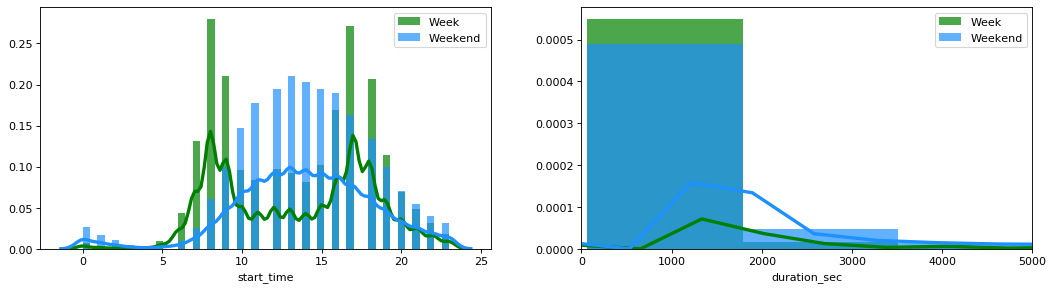

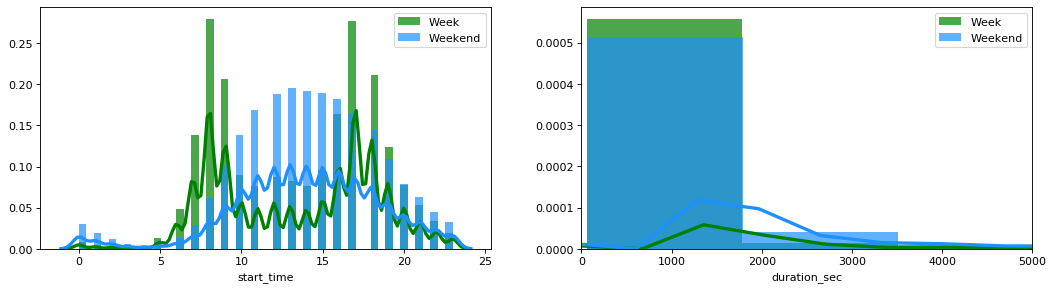

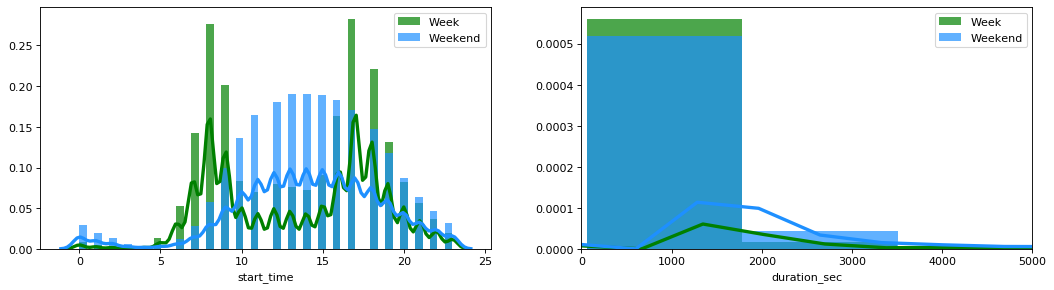

In [11]:
# Compare differences in usage features between weekdays and weekends for all 3 years separately
compare_week_to_weekend(data_frame_2017_sorted)
compare_week_to_weekend(data_frame_2018_sorted)
compare_week_to_weekend(data_frame_2019_sorted)

### Weekdays vs Weekends

Interestingly, there are significant differences between week and weekend usage. 

- The distribution of start times is basically bimodal during the week with peaks around 7-8 am and 4-5 pm (rush hour). In contrast the distribution of start times on weekends is unimodal with a median around 1-2 pm. 
- The duration of trips is consistently longer on the weekends with a difference in medians ranging between 90-200 seconds (highly significant). 


After exploring monthly trends and weekends vs weekdays a finer understanding of usage dynamics can only be attained at a finer scale by sorting trips by day and station.

In [12]:
# Define function to build a matrix (n_station X n_days) of daily trips from each start station
    
def make_trip_count_matrix(data_frame):
    date_values = data_frame["start_time"].apply(lambda x: x.date().strftime('%Y-%m-%d'))
    unique_date_values = date_values.unique()
    
    unique_start_station_id = data_frame["start_station_id"].unique()
    
    
    num_stations = len(unique_start_station_id)
    num_days = len(unique_date_values)
    trip_count_matrix = np.empty((num_stations,num_days))
    

    print("Number of stations", num_stations, "Number of days", num_days)   
    
    for i, elem_i in enumerate(unique_date_values):
        day_inds = date_values == elem_i
        data_frame_day = data_frame[day_inds]  
        for k, elem_k in enumerate(unique_start_station_id):
            count_tmp = sum(data_frame_day['start_station_id'] == elem_k)
            trip_count_matrix[k,i] = count_tmp
                                
    
    df = pd.DataFrame(index=unique_start_station_id, columns=unique_date_values, data=trip_count_matrix)
    
    return df

With this function I can create a matrix of trip counts for each day and starting station across each year

In [13]:
df_daily_2017 = make_trip_count_matrix(data_frame_2017_sorted)

Number of stations 272 Number of days 187


In [14]:
df_daily_2018 = make_trip_count_matrix(data_frame_2018_sorted)

Number of stations 332 Number of days 365


In [15]:
df_daily_2019 = make_trip_count_matrix(data_frame_2019_sorted)

Number of stations 382 Number of days 243


Sanity check: 2018 is the only complete calendar year available and the number of stations has been increasing year over year.

In [16]:
def make_daily_trip_figures(df):
    # Create Fig and gridspec
    fig = plt.figure(figsize=(16, 10), dpi= 80)
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)
    
    daily_counts = df.sum(axis=0)
    station_counts = df.sum(axis=1)
    
    # Define the axes
    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_right = fig.add_subplot(grid[:-1, -1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1])

    # heatmap on main ax
    ax_main.pcolor(df, cmap='hot_r')
    ax_main.set_xticks(range(1, len(daily_counts), 10))
    xlabels = ax_main.get_xticks()#.tolist()
    ax_main.set_xticklabels(xlabels, rotation=90)
    ax_main.yaxis.label.set_fontsize(14)


    # plot on the bottom
    
    ax_bottom.plot(daily_counts, color='deeppink')
    ax_bottom.set_xlim(0, len(daily_counts))
    ax_bottom.set_ylim(0, 14000)
    ax_bottom.set(ylabel = 'number of trips')
    ax_bottom.yaxis.label.set_fontsize(14)

    # plot in the right
    
    ax_right.plot(station_counts,range(0,len(df)))
    ax_right.set_ylim(0, len(station_counts))
    ax_right.set_yticklabels([])
    ax_right.set_yticks([])
    ax_right.set(xlabel = 'number of trips')
    ax_right.xaxis.label.set_fontsize(14)

    # Decorations
    ax_main.set(title='Heatmap of trips across days and stations', xlabel='days', ylabel='stations')
    ax_main.title.set_fontsize(20)
    ax_main.xaxis.label.set_fontsize(14)
    ax_main.yaxis.label.set_fontsize(14)
    for item in (ax_main.get_xticklabels() + ax_main.get_yticklabels()):
        item.set_fontsize(10)

    # Hide labels to right/bottom plots
    ax_bottom.set_xticklabels([])
    ax_bottom.set_xticks([])

    plt.show()
    return

To better visualize the data I built three plots:

- Main Plot: Heat map of #trips for each station (y-axis) and each day (x-axis)
- Side Plot: Total number of trips for each station across the whole time period.
- Bottom Plot: Total number of trips for each day across all the stations.

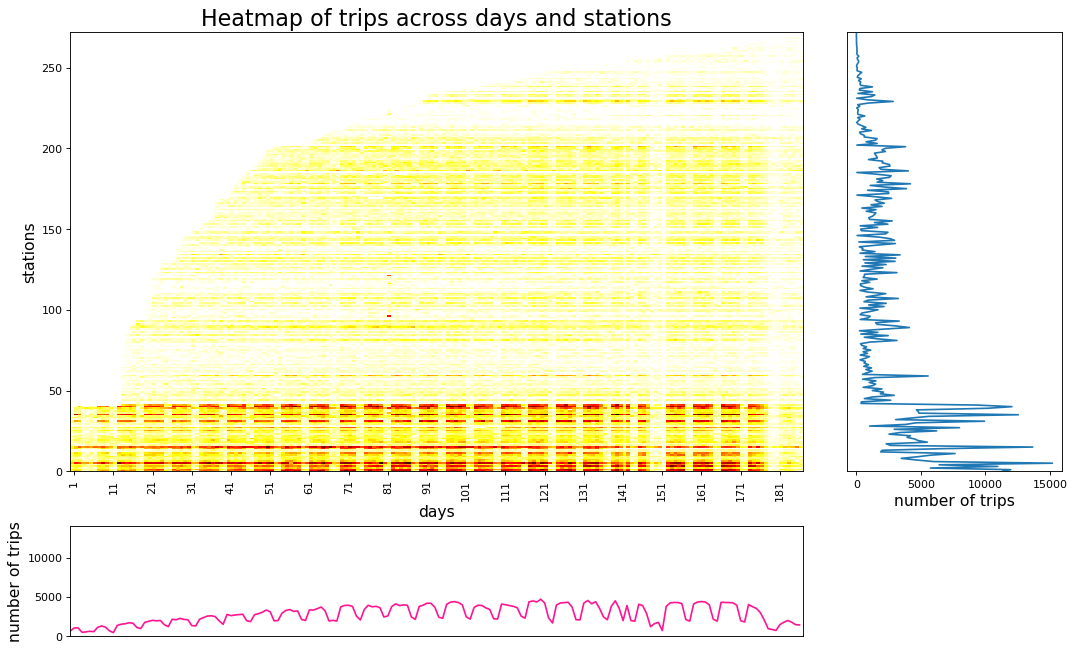

In [17]:
make_daily_trip_figures(df_daily_2017)

This analysis shows many interesting aspects of the data that were previously unacessible: 

1. There was a steep ramp up in the number of stations from <50 to >200 in the first 90 days of the service.

2. There is a periodic aspect to the number of daily trips with evenly spaced dips.

3. The number of trips/station is highly uneven with the most popular stations being consistent throughout the year.

4. White vertical bands across the heatmap indicate days of very low usage across all stations. These happenned most dramatically around the holidays and Christmas.

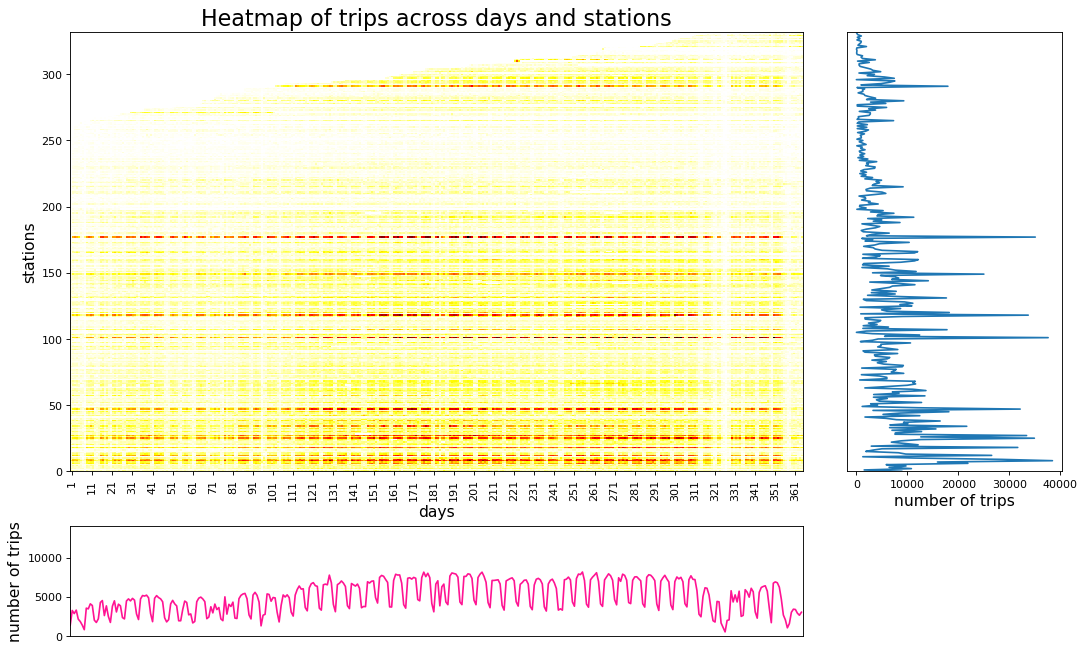

In [18]:
make_daily_trip_figures(df_daily_2018)

The features (2, 3 and 4 above) observed for 2017 also held for 2018. 

The main difference I observed was the decrease on the number of stations added over the course of the year from over 200 in 2017 to 60 in 2018.

but now with the advantage of having a full calendar year to analyse:

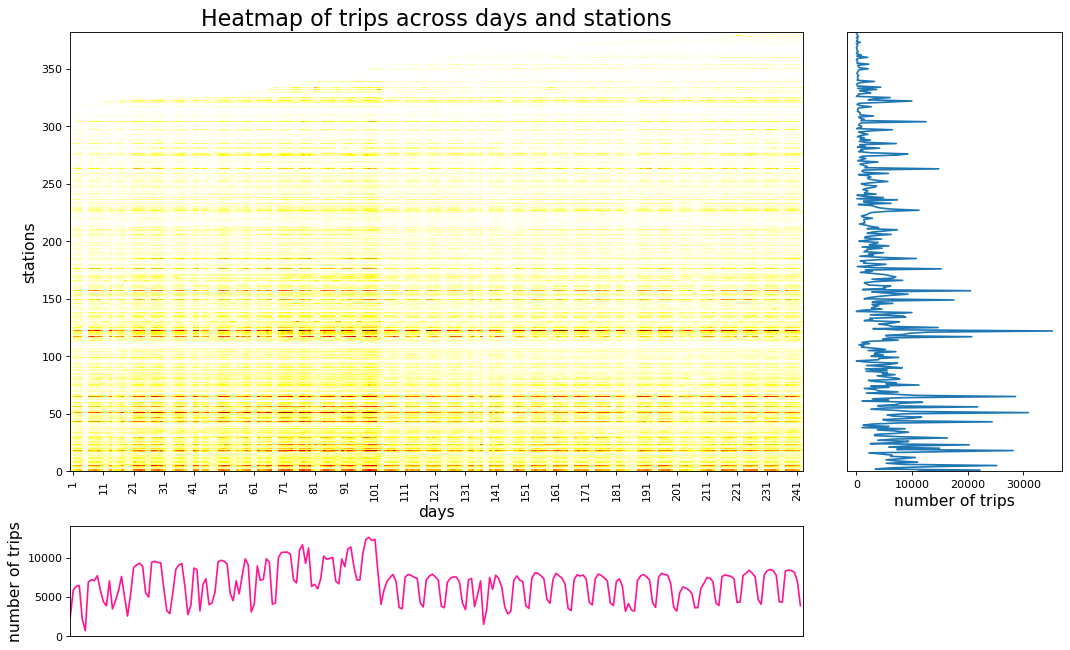

In [19]:
make_daily_trip_figures(df_daily_2019)

In 2019, so far, another 50 stations were added and daily usage grew steadily over the first 100 days of the year (while maintaining its seasonality) ocasionally breaking 10.000 trips/day. After that time point there was a dip in daily usage with peaks barely exceeding 8000 trips/day.

To delve deeper into the station-to-station day-to-day and fluctuations I looked at the structure of the pairwise correlation matrices. 

The station-to-station correlation matrix tells us if/whether the number of trips from two stations fluctuates together or is independent across the year. 

The day-to-day correlation matrix tells us if/whether the number of trips from two days fluctuates together or is independent across all the stations. 

In [20]:
def pairwise_correlation_matrices(df):    
    # Pairwise correlation between stations and between days
    station_corr = df.T.corr(method='pearson')
    day_corr = df.corr(method='pearson')


    # Define the axes
    fig,(ax1, ax2) = plt.subplots(figsize=(20, 8), ncols=2)

    station_im = ax1.imshow(station_corr,  cmap='coolwarm', interpolation='none')
    cbar1 = plt.colorbar(station_im,ax = ax1, spacing='proportional',
                    orientation='vertical', shrink=0.95)
    cbar1.ax.tick_params(labelsize=12) 
    ax1.set(title='Correlation Matrix of station trips across days', xlabel='station', ylabel='station')
    ax1.title.set_fontsize(18)
    ax1.yaxis.label.set_fontsize(16)
    ax1.xaxis.label.set_fontsize(16)

    for item in (ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(12)


    days_im = ax2.imshow(day_corr,  cmap='hot_r', interpolation='none')
    cbar2 = plt.colorbar(days_im,ax = ax2, spacing='proportional',
                    orientation='vertical', shrink=0.95)
    cbar2.ax.tick_params(labelsize=12) 
    ax2.set(title='Correlation Matrix of daily trips across stations', xlabel='day', ylabel='day')
    ax2.title.set_fontsize(18)
    ax2.yaxis.label.set_fontsize(16)
    ax2.xaxis.label.set_fontsize(16)

    for item in (ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(12)

    plt.show()
    
    return    

Because 2018 is the only full calendar year I used it to build intuition and get a comprehensive look across the whole year

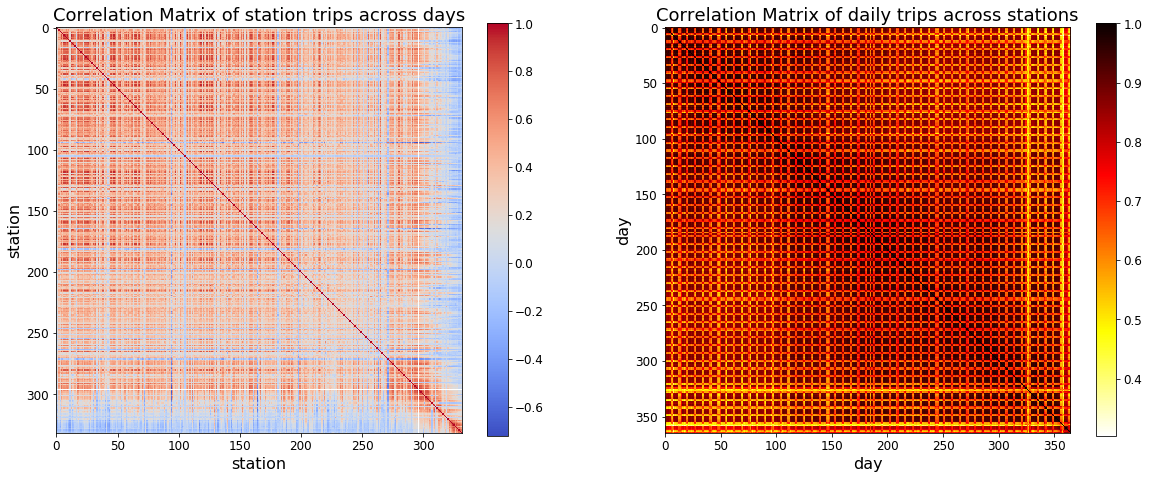

In [21]:
pairwise_correlation_matrices(df_daily_2018)

The station-to-station correlation matrix shows that with some exceptions (most of them being stations added throughout the year) the number of trips from two stations fluctuates together across days. 

The day-to-day correlation matrix shows the number of trips in two days across all the stations fluctuates together in a periodic manner with the main exceptions being days with very low demand during the holiday season.

So far I have only anlysed trips based on their start stations and have not considered the end station as a variable of interest. Knowing how trips are distributed based on start to end location can be informative about the most popular routes and how they have varied over time. 

In [27]:
# Define function to build a matrix (n_station X n_station) of daily trips from each start station to each end station
    
def make_trip_start_end_matrix(data_frame):
#     date_values = data_frame["start_time"].apply(lambda x: x.date().strftime('%Y-%m-%d'))
#     unique_date_values = date_values.unique()
    
    unique_start_station_id = data_frame["start_station_id"].unique()
    unique_end_station_id = data_frame["end_station_id"].unique()
    
    
    num_stations_start = len(unique_start_station_id)
    num_stations_end = len(unique_end_station_id)
#     num_days = len(unique_date_values)
    trip_start_end_matrix = np.empty((num_stations_start,num_stations_end))
    

    print("Number of stations start", num_stations_start, "Number of stations end", num_stations_end)   
    
    for i, elem_i in enumerate(unique_start_station_id):
        start_id_inds = data_frame['start_station_id'] == elem_i
        data_frame_start = data_frame[start_id_inds]  
        for k, elem_k in enumerate(unique_end_station_id):
            count_tmp = sum(data_frame_start['end_station_id'] == elem_k)
            trip_start_end_matrix[i,k] = count_tmp
                                
    
    df = pd.DataFrame(index=unique_start_station_id, columns=unique_end_station_id, data=trip_start_end_matrix)
    
    return df

In [28]:
start_end_matrix_2018 = make_trip_start_end_matrix(data_frame_2018_sorted)

Number of stations start 332 Number of stations end 332


This dataframe now contains the trip counts between every existing start and end station

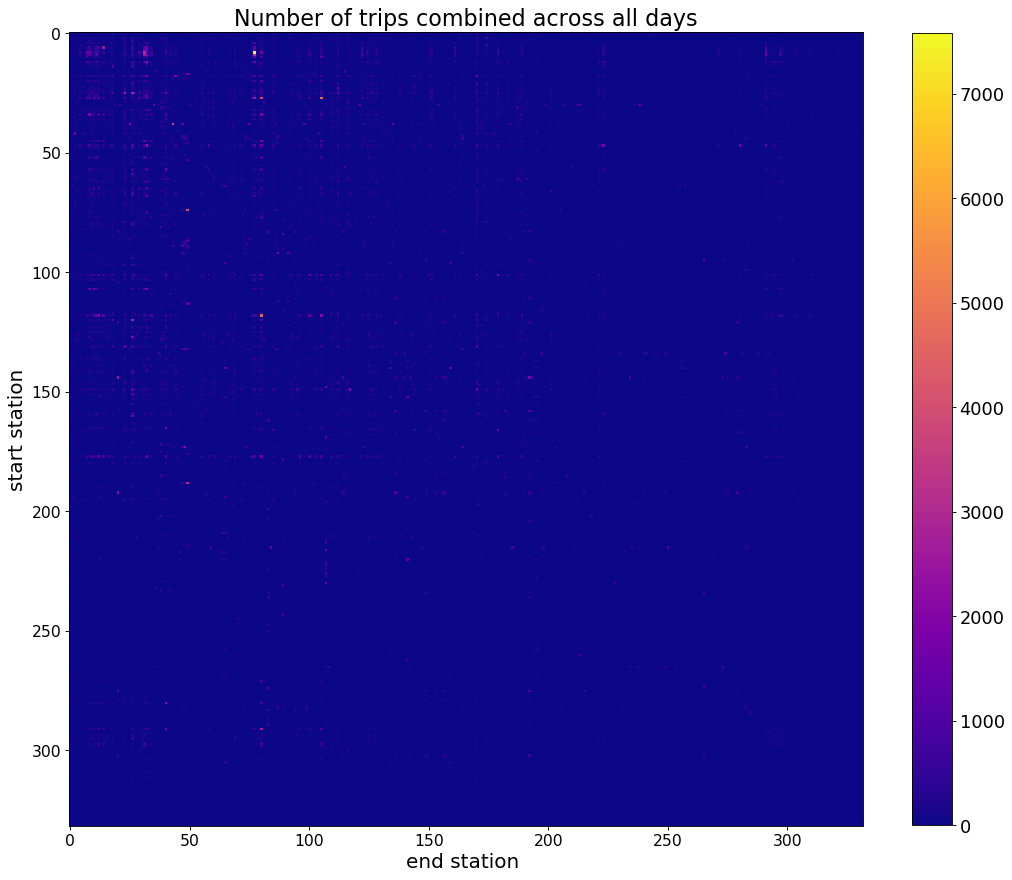

In [112]:
fig = plt.figure(figsize=(16, 16), dpi= 80)
start_end_2018_im = plt.imshow(start_end_matrix_2018,  cmap='plasma', interpolation='none')
ax = plt.gca()
cbar1 = plt.colorbar(start_end_2018_im,ax = ax, spacing='proportional',
                    orientation='vertical', shrink=0.82)
cbar1.ax.tick_params(labelsize=16) 
ax.set(title='Number of trips combined across all days', xlabel='end station', ylabel='start station')
ax.title.set_fontsize(20)
ax.yaxis.label.set_fontsize(18)
ax.xaxis.label.set_fontsize(18)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)


This matrix representation shows the distribution of trips between routes {defined as (start_station,end_station) combinations} is highly uneven with a few very popular routes and many never travelled routes. 

In [125]:
number_of_possible_routes = start_end_matrix_2018.shape[0]*start_end_matrix_2018.shape[1]
print("Number of never travelled routes:", np.count_nonzero(start_end_matrix_2018 == 0), "out of", number_of_possible_routes,"possible routes" )

Number of never travelled routes: 76496 out of 110224 possible routes


Over 70% of the routes were never even traveled during the entire year of 2018!
Another way to look at the data is to sort the routes from most to least travelled.

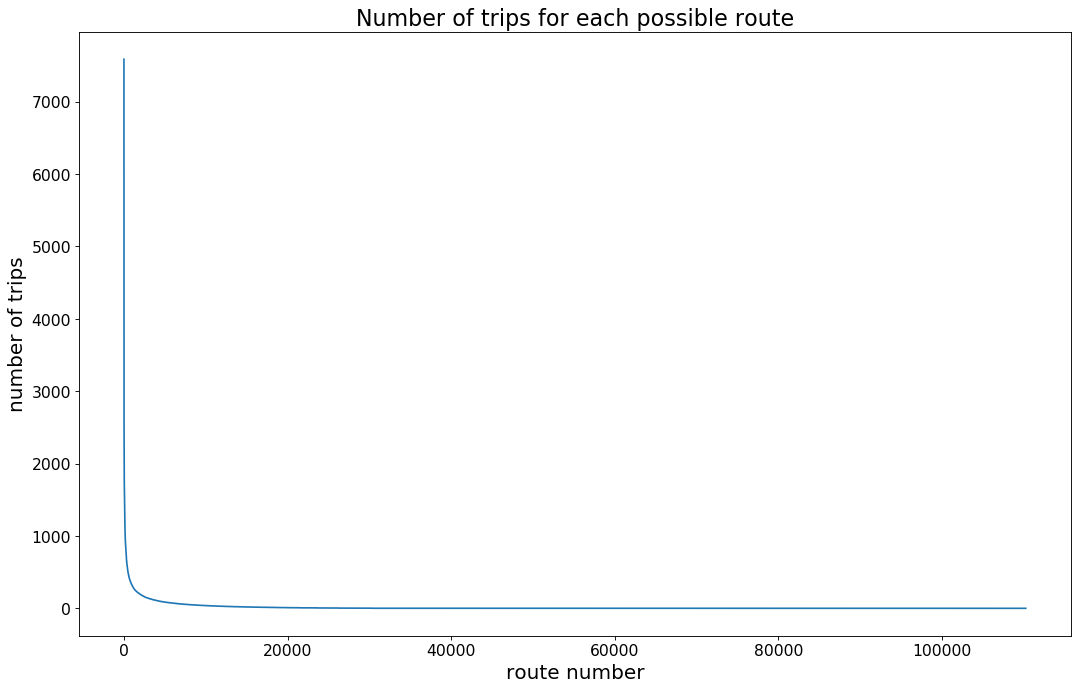

In [126]:
flat_start_end_matrix_2018 = start_end_matrix_2018.values.flatten()
sorted_flat_start_end_matrix_2018 = sorted(flat_start_end_matrix_2018,reverse = True)

fig = plt.figure(figsize=(16, 10), dpi= 80)
plt.plot(sorted_flat_start_end_matrix_2018)
ax_2 = plt.gca()
ax_2.set(title='Number of trips for each possible route', xlabel='route number', ylabel='number of trips')
ax_2.title.set_fontsize(20)
ax_2.yaxis.label.set_fontsize(18)
ax_2.xaxis.label.set_fontsize(18)
for item in (ax_2.get_xticklabels() + ax_2.get_yticklabels()):
        item.set_fontsize(14)

The number of trip/route decays extremely fast. We can quantify that decay as follows:

In [152]:
num_trips_top_routes = np.sum(sorted_flat_start_end_matrix_2018[0:1000])
total_num_trips = np.sum(sorted_flat_start_end_matrix_2018)
print("Top 1000 routes account for %.0f%% of all trips" % (num_trips_top_routes/total_num_trips * 100))

Top 1000 routes account for 37% of all trips


In summary the top 1% of routes accounts for 37% of the total trips across an entire year. This shows the trips are highly structured and there is high demand for specific start to end routes. 

In [154]:
# All to all chord diagram of trips between stations: year by year

## Forecasting

Being able to forecast use is a crucial ability that informs business strategies and decisions. 
Here I tackled the issue of predicting the number of daily trips across all stations.

Because I had already calculated the daily use matrix I just needed to sum the trip counts across all stations

In [155]:
daily_counts_2017 = df_daily_2017.sum(axis=0)
daily_counts_2018 = df_daily_2018.sum(axis=0)
daily_counts_2019 = df_daily_2019.sum(axis=0)

Then to make it easier to manipulate the data I copied the daily counts for each year to numpy arrays and converted them to 'float32' data type

In [156]:
daily_counts_2017_array = daily_counts_2017.to_numpy(copy=True).astype('float32')
daily_counts_2018_array = daily_counts_2018.to_numpy(copy=True).astype('float32')
daily_counts_2019_array = daily_counts_2019.to_numpy(copy=True).astype('float32')

Before tackling the actual prediction problem I defined a some helper function for splitting the data into shuffled batches for the purpose of training the models

In [157]:
# Define function to create windowed dataset with features and labels

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Then I defined the train and test sets. For simplicity I used the data from 2017 and 2018 for training and the data from 2019 (so far) for testing. To avoid an exploding gradients problem I zscored the input features before training the models.

In [158]:
# Create Train and Test sets

full_series = np.concatenate((daily_counts_2017_array,daily_counts_2018_array,daily_counts_2019_array))
time_real = np.arange(len(full_series), dtype="float32")
split_time_real = len(daily_counts_2017_array) + len(daily_counts_2018_array)

full_series_mean = np.mean(full_series)
full_series_std = np.std(full_series)
full_series_z = spstats.zscore(full_series)

x_train_real = full_series[:split_time_real]
x_valid_real = full_series[split_time_real:]

x_train_real_z = full_series_z[:split_time_real]
x_valid_real_z = full_series_z[split_time_real:]

time_train_real = time_real[:split_time_real]
time_valid_real = time_real[split_time_real:]

# Define parameters
window_size_real = 20
batch_size_real = 32
shuffle_buffer_size_real = 1000

dataset_real = windowed_dataset(x_train_real_z, window_size_real, batch_size_real, shuffle_buffer_size_real)


In [159]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Before training any neural networks it's important to define a performance benchmark. My benchmark for performance was a linear regression using historical data since we are attempting to predict a continuous variable (number of trips/day). The number of previous days used to predict day t is defined by `window_size_real`

The linear regression model fits one layer weight to each regressor (previous days counts) and one intercept term.

In [160]:
#How well can you predict #trips a day based on historical data?
l0 = tf.keras.layers.Dense(1, input_shape=[window_size_real])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset_real,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[ 0.19337836],
       [-0.32419157],
       [ 0.23480582],
       [-0.11035427],
       [-0.22026081],
       [ 0.15670447],
       [ 0.41611114],
       [-0.19922696],
       [ 0.03541636],
       [ 0.0006368 ],
       [ 0.03902874],
       [-0.31968465],
       [ 0.01834604],
       [ 0.08554547],
       [ 0.40879625],
       [-0.00475241],
       [-0.09852119],
       [ 0.07243202],
       [ 0.38817364],
       [ 0.17261286]], dtype=float32), array([-0.00688408], dtype=float32)]


Now that the model was trained I could use it to make predictions for the test data (2019)

1170.9581

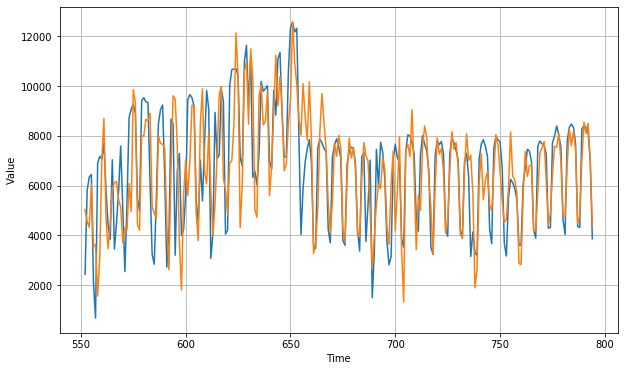

In [161]:
forecast = []

for time in range(len(full_series) - window_size_real):
    forecast.append(model.predict(full_series_z[time:time + window_size_real][np.newaxis]))

forecast_real = forecast[split_time_real-window_size_real:]
results_real = np.array(forecast_real)[:, 0, 0]

plt.figure(figsize=(10, 6))

results_real_rescaled = results_real*full_series_std 
results_real_rescaled = results_real_rescaled + full_series_mean

plot_series(time_valid_real, x_valid_real)
plot_series(time_valid_real, results_real_rescaled)

tf.keras.metrics.mean_absolute_error(x_valid_real, results_real_rescaled).numpy()

Linear regression does a pretty good job at tracking the weekly seasonality and sets a benchmark mean absolute error for the neural networks to attempt to beat. The first NN I tried was a DNN with relu activation functions.

In [165]:
#Can NN beat simple forecasting analyses (Linear Regression)?
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size_real], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())
model.fit(dataset_real,epochs=100,verbose=0)


1057.7084

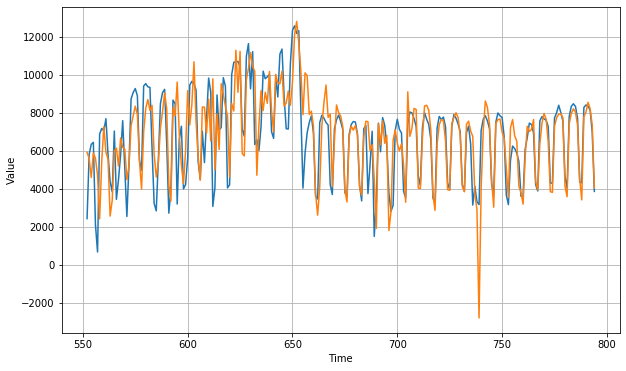

In [166]:
forecast = []

for time in range(len(full_series) - window_size_real):
    forecast.append(model.predict(full_series_z[time:time + window_size_real][np.newaxis]))

forecast_real = forecast[split_time_real-window_size_real:]
results_real = np.array(forecast_real)[:, 0, 0]

plt.figure(figsize=(10, 6))

results_real_rescaled = results_real*full_series_std 
results_real_rescaled = results_real_rescaled + full_series_mean

plot_series(time_valid_real, x_valid_real)
plot_series(time_valid_real, results_real_rescaled)

tf.keras.metrics.mean_absolute_error(x_valid_real, results_real_rescaled).numpy()
